# Autoencoders para Detección de Electrocardiogramas Anormales

Como solución, se plantea la construcción de un modelo de autoencoder entrenado exclusivamente con latidos normales (clase mayoritaria). El objetivo es que el modelo aprenda una representación comprimida de los electrocardiogramas (ECG) normales y sea capaz de reconstruirlos con alta precisión. Posteriormente, al presentar al modelo latidos anormales, se espera que la reconstrucción sea deficiente, reflejando un mayor error de reconstrucción que los normales. Esta diferencia en el error podrá utilizarse como criterio para distinguir entre ECG normales y anormales o anómalos.

El autoencoder estará compuesto por una red neuronal completamente conectada (densa), con una arquitectura simétrica: una etapa de codificación que reduce progresivamente la dimensión de los datos, y una etapa de decodificación que intenta reconstruir la señal original. El cuello de botella de la red (capa intermedia de menor dimensión) actuará como representación latente del ECG.

El entrenamiento se realizará utilizando únicamente las muestras etiquetadas como normales. Una vez entrenado, se calculará el error de reconstrucción para todas las muestras (normales y anormales). Comparando este error con un umbral apropiado (que puede estimarse a partir de los errores de los datos normales de validación), se podrá clasificar un nuevo ECG como normal o anormal según si su error de reconstrucción es menor o mayor a dicho umbral.

---
---

## Configuración General del Entorno de Trabajo

Esta sección detecta si el notebook está corriendo en un entorno COLAB o en uno LOCAL . Monta la carpeta de Google Drive si corresponde y define constantes para trabajar de forma general con cualquir script. Modificar las definiciones de las carpetas según el entorno y configuración del mismo.

In [1]:
ColabNotebook = 'google.colab' in str(get_ipython())

if ColabNotebook:
    # monta G-drive en entorno COLAB
    from google.colab import drive
    drive.mount('/content/drive/')

    # carpeta donde se encuentran archivos .py auxiliares
    FUENTES_DIR = '/content/drive/MyDrive/Colab Notebooks/FUENTES/'
    DATOS_DIR = '/content/drive/MyDrive/Colab Notebooks/DATOS/'      # carpeta donde se encuentran los datasets
    LOCAL_DIR = './DATOS/'  # carpeta local en maquina virtual
else:
    # configuración para notebook con instalación LOCAL
    FUENTES_DIR = '../../FUENTES'         # carpeta donde se encuentran archivos .py auxiliares
    DATOS_DIR   = '../../DATOS/' # carpeta donde se encuentran los datasets
    LOCAL_DIR = DATOS_DIR

# agrega ruta de busqueda donde tenemos archivos .py
import sys
sys.path.append(FUENTES_DIR)

Mounted at /content/drive/


## Inclusión de paquetes

In [2]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, callbacks
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import MinMaxScaler

## Carga de Datos e Inspección
Se carga el dataset a partir de un archivo CSV. Cada fila representa un latido cardíaco y está compuesta por 140 valores que corresponden a una secuencia de la señal ECG, digitalizada y estandarizada. La última columna contiene la etiqueta asociada, donde el valor 1 indica un latido normal y el valor 0, un latido anormal.

In [3]:
nombre_archivo = DATOS_DIR + 'ecg.csv'

# carga archivo de datos. No tiene fila con titulos!
df= pd.read_csv(nombre_archivo, header=None)

raw_data = df.values
df.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


## Preparación de Datos y Normalización

Se separan las etiquetas y las señales ECG a partir del arreglo cargado. Las etiquetas se toman de la última columna, mientras que las primeras 140 columnas corresponden a las lecturas de la señal. Dado que las etiquetas están representadas como valores flotantes (0.0 o 1.0), se las convierte explícitamente a enteros para facilitar su manejo.

Luego, se divide el conjunto de datos en entrenamiento y prueba, reservando el 20% de las muestras para testeo. Para asegurar la reproducibilidad, se fija una semilla aleatoria.

Luego, se normalizan las señales mediante escalado Min-Max, ajustando los valores para que queden en el rango [0, 1]. Esta transformación es adecuada, dado que las señales ECG ya están acotadas en su rango de intensidades.

Finalmente, se separan los datos normales y anormales tanto para el conjunto de entrenamiento como para el de prueba. Esto permitirá entrenar el autoencoder únicamente con ejemplos normales, y evaluar luego su desempeño diferenciando entre ambos tipos de señales.

In [4]:
# separa en etiquetas y datos
FEAT_CNT = 140

labels = raw_data[:, -1]    # Etiquetas (última columna)
data = raw_data[:, 0:-1]  # Datos (secuencia de 140 lecturas)


labels = labels.astype(int) # ajustas etiquetas porque tiene valores en punto flotante (0.0/1.0)

# separa en datos de entrenamiento y testeo
train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=1
)

# Normalización de datos entre 0 y 1. Los datos son lecturas de una señal acotada en intensidad
scaler = MinMaxScaler()

train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

normal_train_data = train_data[train_labels == 1]
normal_test_data = test_data[test_labels == 1]

anomal_train_data = train_data[train_labels == 0]
anomal_test_data = test_data[test_labels == 0]

## Visualización de Ejemplo de ECG Normal y Anormal

Se grafican ejemplos de señales ECG normales y anormales para apreciar visualmente sus diferencias.

Se genera una figura compuesta por dos filas: la primera fila corresponde a señales normales (en color naranja), y la segunda, a señales anormales. En todos los casos, se representa la evolución de la señal a lo largo de sus 140 muestras.


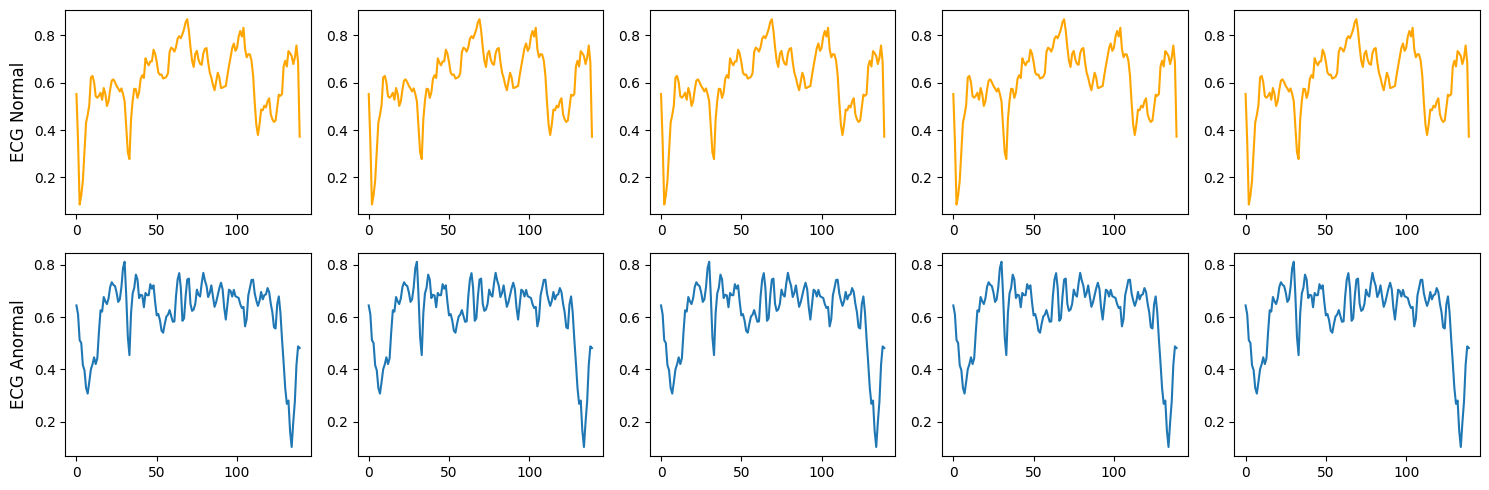

In [5]:
MOSTRAR = 5

fig, axs = plt.subplots(2, MOSTRAR, figsize=(15, 5))  # Ajusta el tamaño de la figura según sea necesario

for i in range(2):
    for j in range(MOSTRAR):
        if i == 0:
            axs[i, j].plot(np.arange(FEAT_CNT), normal_train_data[i], color='orange')  # Cambiar el color de la segunda fila a naranja
        else:
            axs[i, j].plot(np.arange(FEAT_CNT), anomal_train_data[i])  # Gráficos predeterminados para la primera fila

        #axs[i, j].spines['right'].set_visible(False)

# Agregar títulos
axs[0, 0].set_ylabel('ECG Normal' , fontsize=12)
axs[1, 0].set_ylabel('ECG Anormal', fontsize=12)

plt.tight_layout()  # Ajustar automáticamente el espaciado entre subgráficos
plt.show()


## Construcción del Modelo de Autoencoder

Se implementa un autoencoder utilizando la API secuencial de Keras, compuesto por dos bloques principales: un codificador y un decodificador.

### Codificador (encoder)

El codificador transforma las señales ECG originales (de 140 dimensiones) en una representación latente de menor dimensión. Está compuesto por varias capas densas (fully connected) con activación ReLU, con regularización L2, normalización por lotes (BatchNormalization) y Dropout. Esta combinación busca reducir el sobreajuste y estabilizar el entrenamiento. La dimensión del espacio latente (se establece en 16) debe tener tal equilibrio que permita la captura de una representación comprimida pero suficientemente expresiva para permitir la reconstrucción de las señales normales.

### Decodificador (decoder)

El decodificador toma la representación latente y reconstruye la señal original. Tiene una arquitectura simétrica respecto al codificador, también incorpora regularización L2, normalización por lotes y Dropout. La capa de salida tiene 140 unidades (misma que la entrada del codificador) con activación sigmoide, ya que los datos fueron previamente normalizados en el rango [0, 1].

### Compilación del modelo

El autoencoder completo se define como un modelo funcional que une el codificador y el decodificador. Se compila utilizando el optimizador Adam con una tasa de aprendizaje reducida (0.0001) para permitir una convergencia más suave. La función de pérdida/costo elegida es el error cuadrático medio (mean squared error, mse), complementada con el error absoluto medio (mae) como métrica adicional para monitorear el desempeño.

In [ ]:
from tensorflow.keras import layers, regularizers

# Codificador mejorado
encoder = tf.keras.Sequential([
    layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(64, activation="relu", kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dense(32, activation="relu"),
    layers.Dense(16, activation="relu")],  # Espacio latente más grande que 8
    name='Encoder'
)

# Decodificador mejorado
decoder = tf.keras.Sequential([
    layers.Dense(32, activation="relu", kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dense(64, activation="relu", kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(128, activation="relu"),
    layers.Dense(140, activation="sigmoid")],  # Mantenemos sigmoid para salida normalizada
    name='Decoder'
)

# Modelo completo del autoencoder
inputs = tf.keras.Input(shape=(140,))
encoded = encoder(inputs)
decoded = decoder(encoded)

autoencoder = tf.keras.Model( # Por qué decimos que es un modelo secuencial y no funcional?
    inputs=inputs,
    outputs=decoded,
    name='ECG_Autoencoder'
)

# Compilación con optimizador ajustado
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='mse',
                  metrics=['mae'])


print(encoder.summary())
print(decoder.summary())
print(autoencoder.summary())


Model: "Encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        18,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           528 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,680 (115.94 KB)

 Trainable params: 29,296 (114.44 KB)

 Non-trainable params: 384 (1.50 KB)

None


Model: "Decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 140)            │        18,060 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,420 (114.92 KB)

 Trainable params: 29,228 (114.17 KB)

 Non-trainable params: 192 (768.00 B)

None


Model: "ECG_Autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 140)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Encoder (Sequential)            │ (None, 16)             │        29,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Decoder (Sequential)            │ (None, 140)            │        29,420 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,100 (230.86 KB)

 Trainable params: 58,524 (228.61 KB)

 Non-trainable params: 576 (2.25 KB)

None


## Entrenamiento del Modelo

El modelo se entrena utilizando únicamente señales normales, tanto como entrada como como objetivo de salida. Esto permite que el autoencoder aprenda a reconstruir patrones normales de ECG, de modo que las reconstrucciones de señales anómalas —que difieren de lo aprendido— resulten menos precisas y con errores mayores.

Para mejorar el entrenamiento, se emplea una estrategia de early stopping, que monitorea la pérdida de validación (val_loss). Si esta métrica no mejora durante 10 épocas consecutivas (patience=10), el proceso de entrenamiento se interrumpe de forma anticipada. Además, se restauran automáticamente los pesos correspondientes a la época con mejor desempeño en validación, evitando así el sobreajuste.

El entrenamiento se realiza por un máximo de 300 épocas, con un tamaño de lote de 64 muestras. Se incluye el conjunto de prueba (con señales normales y anormales) como conjunto de validación, lo cual permite observar la capacidad de evolucionación del modelo para reconstruir señales en general.

In [7]:
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',  # Monitorea la pérdida de validación
    patience=10,         # Número de épocas sin mejora antes de detener
    restore_best_weights=True,  # Restaura los mejores pesos encontrados
)

history = autoencoder.fit(
    normal_train_data,
    normal_train_data,
    epochs=300,
    batch_size=64,
    validation_data=(test_data, test_data),
    shuffle=True,
    callbacks=[early_stopping]
)

Epoch 1/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 15s 188ms/step - loss: 0.3268 - mae: 0.1696 - val_loss: 0.3032 - val_mae: 0.1497
Epoch 2/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3047 - mae: 0.1481 - val_loss: 0.2887 - val_mae: 0.1428
Epoch 3/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2855 - mae: 0.1309 - val_loss: 0.2741 - val_mae: 0.1337
Epoch 4/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2685 - mae: 0.1172 - val_loss: 0.2596 - val_mae: 0.1228
Epoch 5/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2529 - mae: 0.1050 - val_loss: 0.2456 - val_mae: 0.1113
Epoch 6/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2388 - mae: 0.0950 - val_loss: 0.2325 - val_mae: 0.1011
Epoch 7/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2258 - mae: 0.0867 - val_loss: 0.2207 - val_mae: 0.0932
Epoch 8/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2139 - mae: 0.0799 - val_loss: 0.2098 - val_mae: 0.0871
Epoch 9/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0

## Visualización de las métricas de entrenamiento
Gráfica interactiva para visualizar la evolución de las métricas registradas durante el entrenamiento del modelo. El eje horizontal representa el número de épocas, mientras que el eje vertical muestra el valor de cada métrica.


In [9]:
import plotly.graph_objects as go

fig = go.Figure()

# Recorre el historial para agregar todas las métricas automáticamente
for metric_name, metric_values in history.history.items():
    modo = 'lines' if 'loss' in metric_name else 'markers+lines'
    fig.add_trace(
        go.Scatter(
            y=metric_values,
            name=metric_name,
            mode=modo
        )
    )

fig.update_layout(
    title='Métricas de Entrenamiento',
    xaxis_title='Épocas',
    yaxis_title='Valor',
    template='plotly_white'
)

fig.show()

## Reconstrucción de ECG Normal y Anormal

Visualización de la reconstrucción de un ejemplo de ECG normal y uno anómalo del conjunto de prueba, con el objetivo de analizar la capacidad del autoencoder para reconstruir señales.

Se calcula la representación latente de cada señal mediante el codificador, y luego se obtiene su reconstrucción utilizando el decodificador. En el gráfico se compone de dos figuras (señal normal vs. señal anomala) donde cada una muestra la señal original en negro, la señal reconstruida en color (verde o rojo respectivamente) y el área de las diferencias para visualizar efectivamente el error. En la parte inferior de las figuras se muestra una barra por cada punto, que representa el error absoluto entre el valor original y el reconstruido.

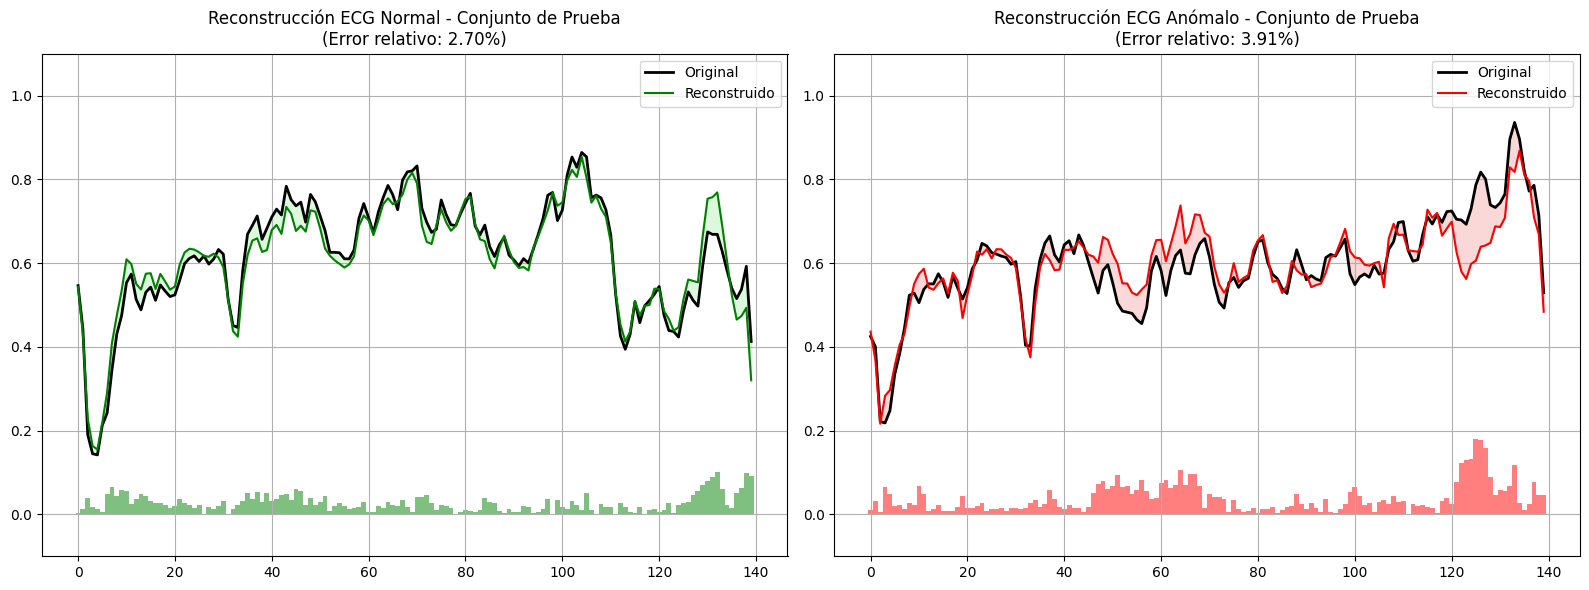

In [10]:
plt.figure(figsize=(16, 6))

# Calcula las reconstrucciones con el dataset de prueba
# ECG Normal
encoded_normal = encoder(normal_test_data).numpy()
decoded_normal = decoder(encoded_normal).numpy()

# ECG Anómalo
encoded_anomal = encoder(anomal_test_data).numpy()
decoded_anomal = decoder(encoded_anomal).numpy()

########## ECG Normal ##########
plt.subplot(1, 2, 1)
plt.title("Reconstrucción ECG Normal - Conjunto de Prueba\n(Error relativo: {:.2f}%)".format(
    100*np.mean(np.abs(normal_test_data[0] - decoded_normal[0]))))
plt.plot(normal_test_data[0], 'black', linewidth=2, label="Original")
plt.plot(decoded_normal[0], 'green', linewidth=1.5, label="Reconstruido")
plt.fill_between(np.arange(140), normal_test_data[0], decoded_normal[0],
                color='lightgreen', alpha=0.3)

# Error relativo por punto
point_error_normal = np.abs(normal_test_data[0] - decoded_normal[0])
plt.bar(np.arange(140), point_error_normal, color='green', alpha=0.5, width=1)

plt.legend()
plt.grid(True)
plt.ylim(-0.1, 1.1)

########## ECG Anómalo ###########
plt.subplot(1, 2, 2)
plt.title("Reconstrucción ECG Anómalo - Conjunto de Prueba\n(Error relativo: {:.2f}%)".format(
    100*np.mean(np.abs(anomal_test_data[0] - decoded_anomal[0]))))
plt.plot(anomal_test_data[0], 'black', linewidth=2, label="Original")
plt.plot(decoded_anomal[0], 'red', linewidth=1.5, label="Reconstruido")
plt.fill_between(np.arange(140), anomal_test_data[0], decoded_anomal[0],
                color='lightcoral', alpha=0.3)

# Grafica elrror relativo por punto
point_error_anomal = np.abs(anomal_test_data[0] - decoded_anomal[0])
plt.bar(np.arange(140), point_error_anomal, color='red', alpha=0.5, width=1)

plt.legend()
plt.grid(True)
plt.ylim(-0.1, 1.1)

plt.tight_layout()
plt.show()

## Análisis de Errores de Reconstrucción

Los siguientes gráficos muestran la capacidad del autoencoder de distinguir entre señales normales y anómalas, se calcula el error absoluto medio (MAE) entre cada señal de prueba y su correspondiente reconstrucción.

### Señales normales

En el primer gráfico (arriba a la izquierda), se muestra un histograma de los errores de reconstrucción de las señales normales del conjunto de prueba. La mayoría de los errores se agrupan en torno a un valor bajo, lo que indica que el modelo logra reconstruir correctamente este tipo de señales. Se grafican la media (línea negra punteada) y una desviación estándar por encima y por debajo de la media (líneas azules punteadas).

### Señales anómalas

En el segundo gráfico (arriba a la derecha), se representa la distribución de errores para señales anómalas. Los errores son considerablemente más altos y su dispersión también es mayor, lo que sugiere que el modelo tiene dificultades para reconstruir señales que no pertenecen al patrón aprendido durante el entrenamiento.

### Comparación conjunta

El gráfico inferior compara ambas distribuciones mediante curvas de densidad. Se observa una clara separación entre los errores típicos de reconstrucción para señales normales (en verde) y anómalas (en rojo). Esta diferencia puede ser aprovechada para establecer un umbral para clasificar automáticamente nuevos señales como normales o anormales según su error de reconstrucción.

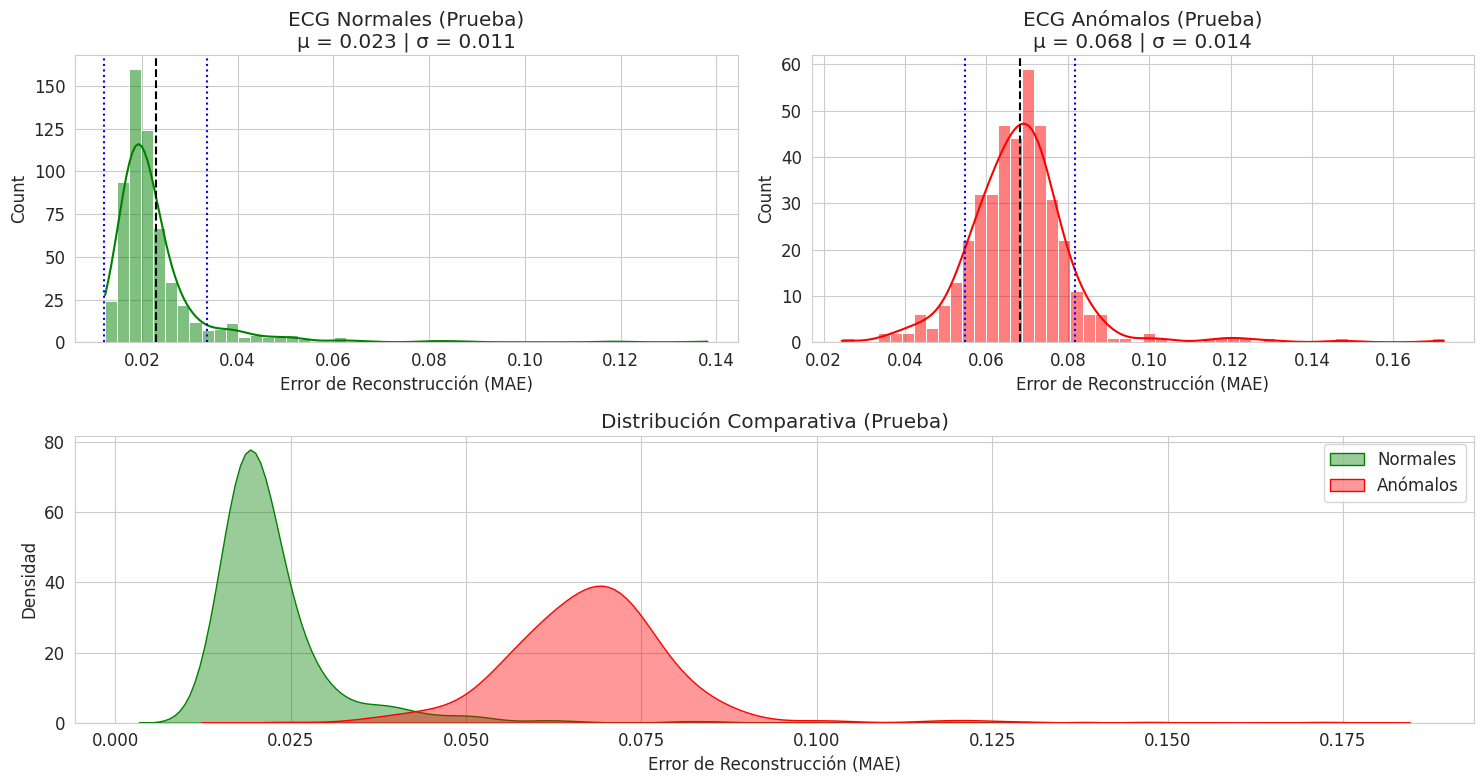

In [ ]:
import matplotlib.pyplot as pltfuncional
import seaborn as sns
import numpy as np

# Configuración
plt.figure(figsize=(15, 8))
sns.set_style("whitegrid")
plt.rcParams['font.size'] = 12

# Calcula predicciones con datos de prueba
pred_normal = autoencoder.predict(normal_test_data, verbose=0)
pred_anormal = autoencoder.predict(anomal_test_data, verbose=0)

# Calcula errores de reconstrucción
prb_normal = tf.keras.losses.mae(pred_normal, normal_test_data)
prb_anomalo = tf.keras.losses.mae(pred_anormal, anomal_test_data)

# ########## Gráfico 1: Normales ##########
plt.subplot(2, 2, 1)

# calcula media y desvio sobre los ECG normales
media, desvio = np.mean(prb_normal), np.std(prb_normal)

sns.histplot(prb_normal, color='green', kde=True, bins=50)

plt.axvline(media, color='black', linestyle='--', linewidth=1.5)
plt.axvline(media + desvio, color='blue', linestyle=':', linewidth=1.5)
plt.axvline(media - desvio, color='blue', linestyle=':', linewidth=1.5)
plt.title(f'ECG Normales (Prueba)\nμ = {media:.3f} | σ = {desvio:.3f}')
plt.xlabel('Error de Reconstrucción (MAE)')

# ########## Gráfico 2: Anómalos ##########
plt.subplot(2, 2, 2)

# calcula media y desvio sobre los ECG normales
media, desvio = np.mean(prb_anomalo), np.std(prb_anomalo)

sns.histplot(prb_anomalo, color='red', kde=True, bins=50)

plt.axvline(media, color='black', linestyle='--', linewidth=1.5)
plt.axvline(media + desvio, color='blue', linestyle=':', linewidth=1.5)
plt.axvline(media - desvio, color='blue', linestyle=':', linewidth=1.5)
plt.title(f'ECG Anómalos (Prueba)\nμ = {media:.3f} | σ = {desvio:.3f}')
plt.xlabel('Error de Reconstrucción (MAE)')

# ########## Gráfico 3: Combinación ##########
plt.subplot(2, 1, 2)
sns.kdeplot(prb_normal, color='green', label='Normales', fill=True, alpha=0.4)
sns.kdeplot(prb_anomalo, color='red', label='Anómalos', fill=True, alpha=0.4)
plt.title('Distribución Comparativa (Prueba)')
plt.xlabel('Error de Reconstrucción (MAE)')
plt.ylabel('Densidad')
plt.legend()

plt.tight_layout()
plt.show()

### Evaluación Interactiva del Modelo

se implementa una interfaz interactiva (con ipywidgets). Para explorar un umbral que permita clasificar correctamente las señales como normales o anómalas según su error de reconstrucción.

### Distribución de errores
El primer gráfico muestra las curvas de densidad (para los errores de reconstrucción de señales normales (verde) y anómalas (rojo). Una línea vertical negra representa el umbral seleccionado. Del lado izquierdo del umbral quedan los ECG clasificados como normales (verdaderos positivos y falsos positivos) mientras que del lado dereho qudan los ECG anómalos (verdaderos negativos y falsos negativos).

### Matriz de confusión
El segundo gráfico muestra la matriz de confusión correspondiente al umbral actual. Aquí se observan la cantidad de aciertos y errores cometidos por el modelo al clasificar señales según su error de reconstrucción.

### Métricas de clasificación

Finalmente, se imprime en consola el reporte de clasificación, que incluye métricas como la precisión (precision), la recuperación (recall), el puntaje F1 y el soporte para cada clase. Esta información ayuda a identificar el compromiso entre sensibilidad y especificidad según el umbral elegido.

In [ ]:
import ipywidgets as widgets
from IPython.display import display
from sklearn.metrics import confusion_matrix, classification_report

# Datos de prueba
y_true = np.concatenate([np.ones(len(prb_normal)), np.zeros(len(prb_anomalo))])
y_scores = np.concatenate([prb_normal, prb_anomalo])

# Función para actualizar el gráfico
def plot_with_threshold(umbral):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Gráfico Combinado
    sns.kdeplot(prb_normal, color='green', label='Normales', fill=True, ax=ax1)
    sns.kdeplot(prb_anomalo, color='red', label='Anómalos', fill=True, ax=ax1)
    ax1.axvline(umbral, color='black', linestyle='--', linewidth=2)
    ax1.set_title(f'Distribución de Errores (Umbral={umbral:.3f})')
    ax1.set_xlabel('Error de Reconstrucción (MAE)')
    ax1.set_ylabel('Densidad')
    ax1.legend()

    # Métricas
    y_pred = (y_scores < umbral).astype(int)
    cm = confusion_matrix(y_true, y_pred)

    # Matriz de confusión visual
    ax2.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax2.set_title('Matriz de Confusión')
    tick_marks = [0, 1]
    ax2.set_xticks(tick_marks)
    ax2.set_yticks(tick_marks)
    ax2.set_xticklabels(['Anómalo', 'Normal'], rotation=45)
    ax2.set_yticklabels(['Anómalo', 'Normal'])

    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax2.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.show()

    # Reporte de clasificación
    print("\nMétricas de Clasificación:")
    print(classification_report(y_true, y_pred, target_names=['Anómalo', 'Normal']))

# Rango del slider (entre percentiles 1 y 99)
min_val = 0.005 #np.percentile(y_scores, 1)
max_val = 0.175 #np.percentile(y_scores, 99)

# Crear slider interactivo
widgets.interact(
    plot_with_threshold,
    umbral=widgets.FloatSlider(
        value=(min_val + max_val)/2,
        min=min_val,
        max=max_val,
        step=(max_val - min_val)/100,
        description='Umbral:',
        continuous_update=False,
        layout=widgets.Layout(width='55%')
    )
)
print()

interactive(children=(FloatSlider(value=0.09, continuous_update=False, description='Umbral:', layout=Layout(wi…